### Data Preprocessing by filling missing value with mean of each column 

In [268]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt 

In [269]:
# Read Data
X = pd.read_excel('Credit Data.xlsx')
X = X.dropna(subset=['Default'])
y = X['Default']
X = X.drop(columns='Default')

In [270]:
# Normalize data and store into another pd dataframe
scaler = StandardScaler()
scaler.fit(X)
normalized_data = scaler.transform(X)
normalized_data = pd.DataFrame(normalized_data)
normalized_data.columns = X.columns

In [271]:
# fill in missing values by mean of column
for col in normalized_data.columns:
    normalized_data[col].fillna((normalized_data[col].mean()), inplace=True)
normalized_data.head(5)

,TA,TDE16,TDE17,TDyoy,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy
0,-0.140112,1.540910e-17,-9.155064e-02,1.209607e-17,-2.376545e-17,-6.106489e-02,5.569668e-17,-0.110876,-1.701367e-01,-9.920604e-02,-0.272549,-5.273853e-17,-3.759005e-16,-2.245845e-16,4.691398e-16,2.682023e-16,-0.188985,-0.198446,-0.117581
1,-0.140104,1.540910e-17,-2.781859e-17,1.209607e-17,2.172522e-01,2.100858e-01,1.511732e-01,-0.110751,-1.704761e-01,-9.939326e-02,-0.272140,-2.642007e-01,-1.754581e-01,-2.377496e-01,-2.118828e-01,-1.879347e-01,-0.188931,-0.198446,-0.117744
2,-0.140089,1.540910e-17,-3.260486e-02,1.209607e-17,8.823338e-03,-2.872915e-02,9.830592e-02,-0.110899,-1.704445e-01,-9.945087e-02,-0.267364,-2.610310e-01,-1.718730e-01,-2.245845e-16,4.691398e-16,2.682023e-16,-0.188844,-0.198446,-0.117644
3,-0.140165,1.540910e-17,-2.781859e-17,1.209607e-17,1.001777e-02,-8.763504e-18,5.569668e-17,-0.110547,-2.395044e-16,9.874225e-17,-0.271184,-2.636913e-01,-3.759005e-16,-2.245845e-16,4.691398e-16,2.682023e-16,-0.188876,-0.198441,-0.117688
4,-0.140109,-1.779662e-01,-7.349089e-02,-6.065806e-02,-7.282480e-02,-4.548700e-02,-1.263802e-01,-0.110695,-1.706340e-01,-9.942206e-02,-0.272208,-2.614272e-01,-1.750100e-01,-2.245845e-16,4.691398e-16,2.682023e-16,-0.188876,-0.198441,-0.117688


In [272]:
# check if still have missing values 
null_data = normalized_data[normalized_data.isnull().any(axis=1)]
null_data

,TA,TDE16,TDE17,TDyoy,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy


In [273]:
# Correlation check 
corr = normalized_data.corr()

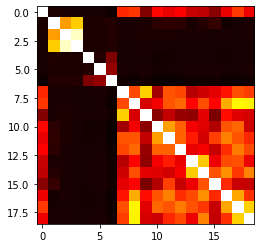

In [274]:
%matplotlib inline
plt.imshow(corr,cmap='hot',interpolation='nearest')

In [275]:
# check if we have correlation between two variables > 0.8
for col in corr.columns:
    for j, val in enumerate(corr[col]):
        if val > 0.8:
            if col != corr.columns[j]:
                print(col,' ',corr.columns[j],val)


TDE17   TDyoy 0.936800444723018
TDyoy   TDE17 0.936800444723018


### Very imbalanced dataset 

In [281]:
# imbalance if dataset
print(len(y[y==1]))
print(len(y[y==0]))
print('ratio of Psotive class for the whole class {}'.format(round(len(y[y==1])/y.shape[0],4)))

546
3661
ratio of Psotive class for the whole class 0.1298


In [282]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normalized_data, y, test_size=0.2, random_state=42)

### Baseline model (Without droppong colinear features and deal with imbalanced dataset)

In [283]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [284]:
# SVM 
svm = SVC()
svm.fit(X_train,y_train)
score_svm = svm.score(X_test,y_test)

print('SVM Score: {}'.format(score_svm))


SVM Score: 0.8836104513064132


In [285]:
# Adaboost  
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
score_ada = ada.score(X_test,y_test)

print('Adaboost Score: {}'.format(score_ada))


Adaboost Score: 0.8812351543942993


In [286]:
# Negative label and posiive label in our testing set 
print(len(y_test[y_test == 0]))
print(len(y_test[y_test == 1]))

742
100


In [287]:
742/842

0.8812351543942993

### Our data only contains 12% positive classes it means that with zeor-information model (classify all labels to 0 ), the model will still have accuracy of 88%,so the above baseline results are not informative in terms of whether the model is being effective. 





### Next, we fist drop the correlated feature (TDyoy) and balance our train/test dataset first

In [288]:
normalized_data = normalized_data.drop(columns = ['TDyoy'])

In [289]:
y = pd.DataFrame(y)
y.columns = ['Default']
positive_idx = y.index[y['Default'] == 1].tolist()
negative_idx = y.index[y['Default'] == 0].tolist()

# this is an empty row I detected due to unknown issue, delete it for now
positive_idx.remove(4207)

In [290]:
len(positive_idx)

545

In [291]:
# train/test with 546 positve and 600 negative labelled data 
subset_neg_idx = negative_idx[:600]
balanced_data = normalized_data.loc[positive_idx].append(normalized_data.loc[subset_neg_idx])
balanced_y = np.array([1]*len(positive_idx) + [0]*len(subset_neg_idx))

In [292]:
balanced_data[balanced_data.isnull().any(axis=1)]

,TA,TDE16,TDE17,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy


In [293]:
# repeat the above process again for training/ testing 

X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_y, test_size=0.2, random_state=42)

# SVM 
svm = SVC()
svm.fit(X_train,y_train)
score_svm = svm.score(X_test,y_test)
print('SVM Score: {}'.format(score_svm))

# Adaboost  
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
score_ada = ada.score(X_test,y_test)
print('Adaboost Score: {}'.format(score_ada))




SVM Score: 0.8384279475982532
Adaboost Score: 0.9912663755458515


In [294]:
# postive/negative samples in our dataset
print(len(y_test[y_test == 0]))
print(len(y_test[y_test == 1]))

112
117


### We can see from above that with our colinear features dropping and a more balanced dataset (even though with much less data avaliable), our SVM model's accuracy drops, while our Adaboost (tree based)  model's accuracy increases hugely. Here with a balanced testing set (112 negative vs 117 postive), if we still use zero-information model, we would get roughly 50% accuracy, so it shows that the two new models are much more effective and useful in terms of differentiaing positive and negative classes. Next step will be hyperparameter tuning, dealing with overfitting and feature importance analysis.